In [1]:
from matplotlib import pyplot as plt
import mne
from mne import io
from mne.datasets import sample
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
data_path = str(sample.data_path())
raw_fname = data_path + "/MEG/sample/sample_audvis_filt-0-40_raw.fif"
event_fname = data_path + "/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif"
tmin, tmax = -0.0, 1
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)

# Setup for reading the raw data
raw = io.Raw(raw_fname, preload=True, verbose=False)
raw.filter(2, None, method="iir")  # replace baselining with high-pass
events = mne.read_events(event_fname)

raw.info["bads"] = ["MEG 2443"]  # set bad channels
picks = mne.pick_types(
    raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads"
)

# Read epochs
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=False,
    picks=picks,
    baseline=None,
    preload=True,
    verbose=False,
)

labels = epochs.events[:, -1]
evoked = epochs.average()
epochs_data = epochs.get_data(copy=False)

Using default location ~/mne_data for sample...
Creating /home/sasha/mne_data


100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 1.74TB/s]
Untarring contents of '/home/sasha/mne_data/MNE-sample-data-processed.tar.gz' to '/home/sasha/mne_data'


Attempting to create new mne-python configuration file:
/home/sasha/.mne/mne-python.json
Download complete in 02m09s (1576.2 MB)
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 2.00 Hz: -6.02 dB



In [8]:
epochs

<Epochs | 288 events (all good), 0 – 0.999 s (baseline off), ~22.8 MiB, data loaded,
 'aud_l': 72
 'aud_r': 73
 'vis_l': 73
 'vis_r': 70>

Classification accuracy: 0.902778 


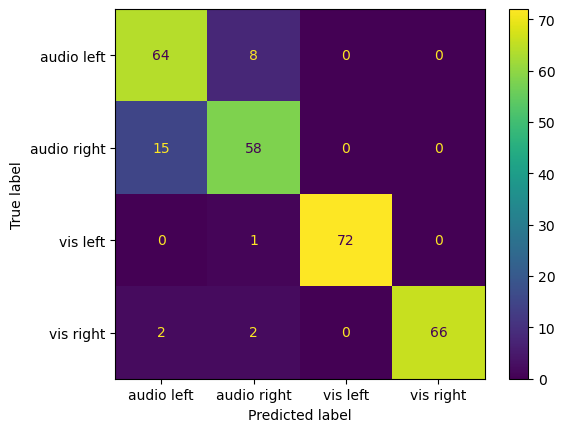

In [3]:
n_components = 2  # pick some components

# Define a monte-carlo cross-validation generator (reduce variance):
cv = KFold(n_splits=10, shuffle=True, random_state=42)

clf = make_pipeline(
    XdawnCovariances(n_components),
    TangentSpace(metric="riemann"),
    LogisticRegression(),
)

preds = np.zeros(len(labels))

for train_idx, test_idx in cv.split(epochs_data):
    y_train, y_test = labels[train_idx], labels[test_idx]

    clf.fit(epochs_data[train_idx], y_train)
    preds[test_idx] = clf.predict(epochs_data[test_idx])

# Printing the results
acc = np.mean(preds == labels)
print("Classification accuracy: %f " % (acc))

names = ["audio left", "audio right", "vis left", "vis right"]
cm = confusion_matrix(labels, preds)
ConfusionMatrixDisplay(cm, display_labels=names).plot()
plt.show()

In [6]:
print(epochs_data.shape)
print(labels.shape)

(288, 60, 151)
(288,)


Число событий 288
Число каналов 60
Время 151